In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()
import sys
sys.path.append('/SNS/users/ntv/integrate/')
import ICCFitTools as ICCFT
import ICConvoluted as ICC
from mantid.simpleapi import *
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import pandas as pd
from tqdm import tqdm


def showTOFFits(i):
    x = fitDictList[i]['x']
    yData = fitDictList[i]['yData']
    yInit = fitDictList[i]['yInit']
    yFit = fitDictList[i]['yFit']
    plt.plot(x,yData,label='Data')
    plt.plot(x,yInit,label='yInit')
    plt.plot(x,yFit,label='yFit')
    plt.title('%4.4f meV'%(fitDictList[i]['energy']))
    plt.legend(loc='best')

tofFileName = 'data/source_IRP2_30o70p_TU_BL11.dat'
#tofFileName = 'data/source_IRP2_BU_BL8.dat'
    
tofData = np.loadtxt(tofFileName,skiprows=171,dtype={'names':('TOF', 'Energy','I','SigI'),
                                                                               'formats':('f','f','f','f')})
uniqueEnergies = np.unique(tofData['Energy'])[::-1]
oldPadeCoefficients = ICCFT.getModeratorCoefficients('/home/ntv/integrate/franz_coefficients_2017.dat')

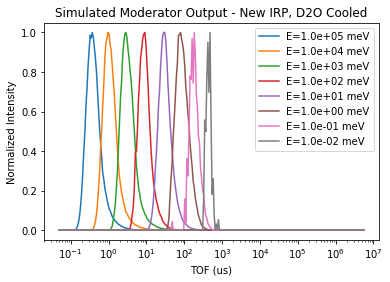

In [2]:
for energy in uniqueEnergies[[0,20,40,60,80,100,120,140]]:
    gIDX = tofData['Energy']==energy
    tof = tofData[gIDX]['TOF']
    y = tofData[gIDX]['I']
    plt.semilogx(tof,y/y.max(),label='E=%4.1e meV'%(energy*1000.))
plt.legend(loc='best')
plt.xlabel('TOF (us)')
plt.ylabel('Normalized Intensity')
plt.title('Simulated Moderator Output - New IRP, D2O Cooled')

In [3]:
fitDictList = []
for energy in tqdm(uniqueEnergies):
    gIDX = tofData['Energy']==energy
    tof = tofData[gIDX]['TOF']
    y = tofData[gIDX]['I']
    y = y/y.max()
    yE = tofData[gIDX]['SigI']/y.max()
    yIDX = y > 1.e-5
    tofWS = CreateWorkspace(DataX=tof[yIDX], DataY=y[yIDX],DataE=yE[yIDX])
    #fitResults = ICCFT.doICCFit(tofWS, energy, 0.1, oldPadeCoefficients)

    fICC = ICC.IkedaCarpenterConvoluted()
    fICC.init()
    fICC['A'] = ICCFT.pade(oldPadeCoefficients['A'],energy)
    fICC['B'] = ICCFT.pade(oldPadeCoefficients['B'],energy)
    fICC['R'] = ICCFT.pade(oldPadeCoefficients['R'],energy)
    fICC['T0'] = ICCFT.pade(oldPadeCoefficients['T0'],energy)
    fICC['T0'] = float(tof[np.argmax(y)])
    fICC['Scale'] = 1.
    fICC['HatWidth'] = 0.5
    fICC['KConv'] = 1200.

    yICC = fICC.function1D(tof[yIDX])
    fICC['Scale'] = 1/np.max(yICC)
    yICC = fICC.function1D(tof[yIDX])



    fitResults = Fit(Function=fICC, InputWorkspace='tofWS')
    yFit = fitResults[2](tofWS.readX(0))

    fitDict = {}
    fitDict['energy'] = energy
    fitDict['x'] = tofWS.readX(0).copy()
    fitDict['yData'] = tofWS.readY(0).copy()
    fitDict['yInit'] = yICC.copy()
    fitDict['yFit']  = yFit.copy()
    fitDict['Alpha'] = fitResults[2]['A']
    fitDict['Beta'] = fitResults[2]['B']
    fitDict['R'] = fitResults[2]['R']
    fitDict['T0'] = fitResults[2]['T0']
    fitDict['Scale'] = fitResults[2]['Scale']
    fitDict['HatWidth'] = fitResults[2]['HatWidth']
    fitDict['KConv'] = fitResults[2]['KConv']
    fitDictList.append(fitDict)

fitDictList = fitDictList[::-1]
slider = widgets.IntSlider(value=len(fitDictList)//2, min=0,max=len(fitDictList)-1, step=1, description='Energy',
                           disabled=False, continuous_update=False, orientation='horizontal',
                           readout=True, readout_format='d')
interact(showTOFFits,i=slider)

  0%|          | 0/141 [00:00<?, ?it/s]/opt/Mantid/plugins/python/functions/ICConvoluted.py:80: RuntimeWarning: overflow encountered in exp
  gc_f = np.exp(-KConv*np.power(gc_x,2))
/opt/Mantid/plugins/python/functions/ICConvoluted.py:81: RuntimeWarning: invalid value encountered in true_divide
  gc_f = gc_f/np.sum(gc_f)
 72%|███████▏  | 102/141 [00:07<00:02, 13.93it/s]/opt/Mantid/plugins/python/functions/ICConvoluted.py:66: RuntimeWarning: overflow encountered in exp
  (np.exp(-B*(t-T0))-np.exp(-A*(t-T0))*(1+(A-B)*(t-T0)+0.5*np.power((A-B),2)*np.power((t-T0),2))))
100%|██████████| 141/141 [00:11<00:00, 12.72it/s]


interactive(children=(IntSlider(value=70, continuous_update=False, description=u'Energy', max=140), Output()), _dom_classes=('widget-interact',))

<function __main__.showTOFFits>

/SNS/users/ntv/integrate/ICCFitTools.py:479: RuntimeWarning: invalid value encountered in power
  return c[0]*x**c[1]*(1+c[2]*x+c[3]*x**2+(x/c[4])**c[5])/(1+c[6]*x+c[7]*x**2+(x/c[8])**c[9])
/SNS/users/ntv/integrate/ICCFitTools.py:479: RuntimeWarning: overflow encountered in power
  return c[0]*x**c[1]*(1+c[2]*x+c[3]*x**2+(x/c[4])**c[5])/(1+c[6]*x+c[7]*x**2+(x/c[8])**c[9])
/SNS/users/ntv/integrate/ICCFitTools.py:479: RuntimeWarning: invalid value encountered in true_divide
  return c[0]*x**c[1]*(1+c[2]*x+c[3]*x**2+(x/c[4])**c[5])/(1+c[6]*x+c[7]*x**2+(x/c[8])**c[9])
/usr/local/lib/python2.7/dist-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


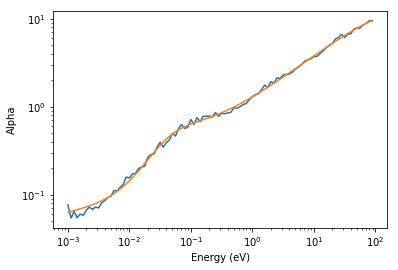

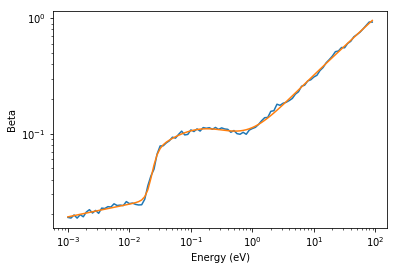

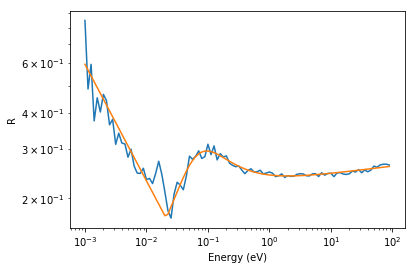

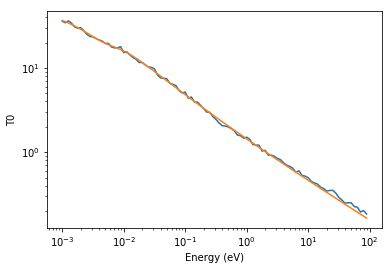

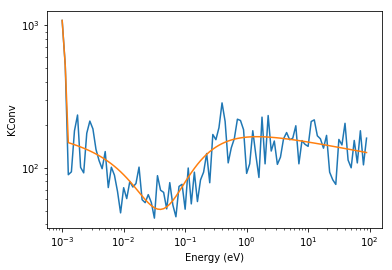

In [4]:
df = pd.DataFrame(fitDictList)
gIDX = (df['energy']>1.e-3) & (df['energy']<100.)
paramsToFit = ['Alpha', 'Beta', 'R', 'T0', 'KConv']
padeKeys = ['A', 'B', 'R', 'T0']
pade2010 = ICCFT.getModeratorCoefficients('/home/ntv/integrate/franz_coefficients_2010.dat')
pade2017 = ICCFT.getModeratorCoefficients('/home/ntv/integrate/franz_coefficients_2017.dat')
newParamList = []
from scipy.optimize import curve_fit
for i, parameter in enumerate(paramsToFit):
    plt.figure(i+1)
    x = np.array(df[gIDX]['energy'])
    y = np.array(df[gIDX][parameter])
    plt.loglog(x,y)
    plt.xlabel('Energy (eV)')
    plt.ylabel(parameter)
    if i != 3:
        if i != 4:
            p, cov = curve_fit(ICCFT.padeWrapper,x,y,p0=pade2017[padeKeys[i]], maxfev=100000)
        else:
            p, cov = curve_fit(ICCFT.padeWrapper,x,y,p0=pade2017[padeKeys[2]], maxfev=100000)
        plt.loglog(x, ICCFT.pade(p,x))
    if i == 3:
        p, cov = curve_fit(ICCFT.padeWrapper,x,y,p0=pade2017[padeKeys[i]], epsfcn=0.001, maxfev=100000)
        plt.loglog(x, ICCFT.pade(p,x))
    newParamList.append(p)

In [5]:
def showPadeTOF(i):
    x = fitDictList[i]['x']
    yData = fitDictList[i]['yData']
    yFit = fitDictList[i]['yFit']
    energy = fitDictList[i]['energy']
    plt.plot(x,yData,label='Data')
    
    fICC = ICC.IkedaCarpenterConvoluted()
    fICC.init()
    fICC['A'] = float(ICCFT.pade(newParamList[0],energy))
    fICC['B'] = float(ICCFT.pade(newParamList[1],energy))
    fICC['R'] = float(ICCFT.pade(newParamList[2],energy))
    fICC['T0'] = float(ICCFT.pade(newParamList[3],energy))
    fICC['KConv'] = float(ICCFT.pade(newParamList[4], energy))
    fICC['HatWidth'] = 0.5
    fICC['Scale'] = 1.
    yModel = fICC.function1D(x)
    fICC['Scale'] = yData.max() / yModel.max()
    yModel = fICC.function1D(x)
    plt.plot(x,yModel,label='Model')
    plt.legend(loc='best')
    plt.title('%4.4f meV'%(energy*1000))
modelSlider = widgets.IntSlider(value=len(fitDictList)//2, min=0,max=len(fitDictList)-1, step=1, description='Energy',
                           disabled=False, continuous_update=False, orientation='horizontal',
                           readout=True, readout_format='d')              
interact(showPadeTOF, i=modelSlider)

interactive(children=(IntSlider(value=70, continuous_update=False, description=u'Energy', max=140), Output()), _dom_classes=('widget-interact',))

<function __main__.showPadeTOF>

In [6]:
outputCoefficients = np.array(newParamList[:4])
np.savetxt('/home/ntv/integrate/bl11_moderatorCoefficients.dat',outputCoefficients)

In [7]:
tofFileName2017 = 'data/bl11_source_inp_pre_38m-115_sp_2017.dat'
tofData2017 = np.loadtxt(tofFileName2017,skiprows=171,dtype={'names':('TOF', 'Energy','I','SigI'),
                                                                               'formats':('f','f','f','f')})

tofFileName2015 = 'data/source_inp_pre_38m-115_2015.dat'
tofData2015 = np.loadtxt(tofFileName2015,skiprows=171,dtype={'names':('TOF', 'Energy','I','SigI'),
                                                                               'formats':('f','f','f','f')})
uniqueEnergies2017 = np.unique(tofData['Energy'])[::-1]
moderatorCoefficients2010 = ICCFT.getModeratorCoefficients('/home/ntv/integrate/franz_coefficients_2010.dat')

def showHistoricTOF(i):
    gIDX = tofData['Energy']==uniqueEnergies[::-1][i]
    tof2018 = tofData[gIDX]['TOF']
    y2018 = tofData[gIDX]['I']
    tof2017 = tofData2017[gIDX]['TOF']
    y2017 = tofData2017[gIDX]['I']
    tof2015 = tofData2015[gIDX]['TOF']
    y2015 = tofData2015[gIDX]['I']
    
    pIDX = y2018/y2018.max() > 1.e-3
    
    fICC = ICC.IkedaCarpenterConvoluted()
    fICC.init()
    fICC['A'] = float(ICCFT.pade(moderatorCoefficients2010['A'],energy*1000))
    fICC['B'] = float(ICCFT.pade(moderatorCoefficients2010['B'],energy*1000))
    fICC['R'] = float(ICCFT.pade(moderatorCoefficients2010['R'],energy*1000))
    fICC['T0'] = float(ICCFT.pade(moderatorCoefficients2010['T0'],energy*1000))
    fICC['KConv'] = 120.
    fICC['HatWidth'] = 0.5
    fICC['Scale'] = 1.
    y2010 = fICC.function1D(tof[pIDX])
    fICC['Scale'] = y2018.max() / y2010.max()
    y2010 = fICC.function1D(tof[pIDX])
    
    
    
    
    plt.plot(tof2018[pIDX],y2018[pIDX],label='2018 - IRP2 D2O Cooled')
    plt.plot(tof2017[pIDX],y2017[pIDX],label='2017 - IRP1 H2O Cooled')
    #plt.plot(tof2015[pIDX],y2015[pIDX],label='2015')
    #plt.plot(tof2018[pIDX],y2010,label='2010 (Not Normalized)')
    plt.legend(loc='best')
    plt.title('%4.2f meV'%(uniqueEnergies[::-1][i]*1000))
historicSlider = widgets.IntSlider(value=len(fitDictList)//2, min=0,max=len(fitDictList)-1, step=1, description='Energy',
                           disabled=False, continuous_update=False, orientation='horizontal',
                           readout=True, readout_format='d')              
interact(showHistoricTOF, i=historicSlider)


interactive(children=(IntSlider(value=70, continuous_update=False, description=u'Energy', max=140), Output()), _dom_classes=('widget-interact',))

<function __main__.showHistoricTOF>